**About Book Crossing Dataset**<br>

This dataset has been compiled by Cai-Nicolas Ziegler in 2004, and it comprises of three tables for users, books and ratings. Explicit ratings are expressed on a scale from 1-10 (higher values denoting higher appreciation) and implicit rating is expressed by 0.

Reference: http://www2.informatik.uni-freiburg.de/~cziegler/BX/ 

**Objective**

This project entails building a Book Recommender System for users based on user-based and item-based collaborative filtering approaches.

#### Execute the below cell to load the datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import pairwise_distances

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading data
books = pd.read_csv("books.csv", sep=";", error_bad_lines=False, encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('users.csv', sep=';', error_bad_lines=False, encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'


### Check no.of records and features given in each dataset

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
ISBN                 271360 non-null object
bookTitle            271360 non-null object
bookAuthor           271359 non-null object
yearOfPublication    271360 non-null object
publisher            271358 non-null object
imageUrlS            271360 non-null object
imageUrlM            271360 non-null object
imageUrlL            271357 non-null object
dtypes: object(8)
memory usage: 16.6+ MB


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
userID      278858 non-null int64
Location    278858 non-null object
Age         168096 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


## Exploring books dataset

In [6]:
books.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


### Drop last three columns containing image URLs which will not be required for analysis

In [7]:
books.drop(['imageUrlS', 'imageUrlM', 'imageUrlL'],axis=1,inplace=True)

In [8]:
books.sample(5)

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
170960,0786929235,Darkness and Light (Dragonlance: Preludes),Paul B. Thompson,2003,Wizards of the Coast
12987,0765107619,Dragonfly Beetle Butterfly Bee (Maryjo Koch Se...,Maryjo Koch,1999,Smithmark Publishers
208884,3596127610,Neon - NÃ?Â¤chte.,Sabine Deitmer,1995,"Fischer (Tb.), Frankfurt"
134519,8433920472,Sonetos de Amor,William Shakespeare,1995,Anagrama
143379,0534213243,Group Counseling: Strategies and Skills (Couns...,Ed E. Jacobs,1993,Thomson Learning College


**yearOfPublication**

### Check unique values of yearOfPublication


In [9]:
unq_yrs = books['yearOfPublication'].unique()
print(f'Unique years Count: {len(unq_yrs)}')
unq_yrs

Unique years Count: 202


array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

As it can be seen from above that there are some incorrect entries in this field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as yearOfPublication in dataset due to some errors in csv file.


Also some of the entries are strings and same years have been entered as numbers in some places. We will try to fix these things in the coming questions.

### Check the rows having 'DK Publishing Inc' as yearOfPublication

In [10]:
books[books['yearOfPublication'] == 'DK Publishing Inc']

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


### Drop the rows having `'DK Publishing Inc'` and `'Gallimard'` as `yearOfPublication`

In [11]:
books = books[(books['yearOfPublication'] != 'DK Publishing Inc') & (books['yearOfPublication'] != 'Gallimard')]

### Change the datatype of yearOfPublication to 'int'

In [12]:
books['yearOfPublication'] = books['yearOfPublication'].astype('int32')

In [13]:
books.dtypes

ISBN                 object
bookTitle            object
bookAuthor           object
yearOfPublication     int32
publisher            object
dtype: object

### Drop NaNs in `'publisher'` column


In [14]:
#drop NaNs in 'publisher' column
books = books.dropna(subset=['publisher'])
books['publisher'].isnull().sum()

0

## Exploring Users dataset

In [15]:
print(users.shape)
users.head()

(278858, 3)


,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


### Get all unique values in ascending order for column `Age`

In [16]:
unq_age = users['Age'].unique()
print(f'Total Unique Ages: {len(unq_age)}')
print(sorted(unq_age))

Total Unique Ages: 166
[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219

Age column has some invalid entries like nan, 0 and very high values like 100 and above

### Values below 5 and above 90 do not make much sense for our book rating case...hence replace these by NaNs

In [17]:
users.loc[(users['Age'] > 90) | (users['Age'] < 5), 'Age'] = np.nan

### Replace null values in column `Age` with mean

In [18]:
users['Age'] = users['Age'].fillna(users['Age'].mean())

### Change the datatype of `Age` to `int`

In [19]:
users['Age'] = users['Age'].astype('int32')

In [20]:
unq_age = users['Age'].unique()
print(f'Total Unique Ages after removing >90 and <5: {len(unq_age)}')
print(sorted(unq_age))

Total Unique Ages after removing >90 and <5: 86
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90]


## Exploring the Ratings Dataset

### check the shape

In [21]:
ratings.shape

(1149780, 3)

In [22]:
n_users = users.shape[0]
n_books = books.shape[0]

In [23]:
ratings.head(5)

,userID,ISBN,bookRating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


### Ratings dataset should have books only which exist in our books dataset. Drop the remaining rows

In [24]:
ratings_mod = ratings[ratings['ISBN'].isin(books['ISBN'])]

### Ratings dataset should have ratings from users which exist in users dataset. Drop the remaining rows

In [25]:
ratings_mod = ratings_mod[ratings_mod['userID'].isin(users['userID'])]

In [26]:
len(ratings_mod)

1031130

### Consider only ratings from 1-10 and leave 0s in column `bookRating`

In [27]:
ratings_mod['bookRating'].unique()

array([ 0,  5,  3,  6,  7,  9,  8, 10,  1,  4,  2], dtype=int64)

In [28]:
ratings_data = ratings_mod[ratings_mod['bookRating'] != 0]
ratings_rem = ratings_mod[ratings_mod['bookRating'] == 0]

In [29]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383839 entries, 1 to 1149778
Data columns (total 3 columns):
userID        383839 non-null int64
ISBN          383839 non-null object
bookRating    383839 non-null int64
dtypes: int64(2), object(1)
memory usage: 11.7+ MB


In [30]:
ratings_rem.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647291 entries, 0 to 1149776
Data columns (total 3 columns):
userID        647291 non-null int64
ISBN          647291 non-null object
bookRating    647291 non-null int64
dtypes: int64(2), object(1)
memory usage: 19.8+ MB


3 rows were removed as the ratings was 0

### Find out which rating has been given highest number of times

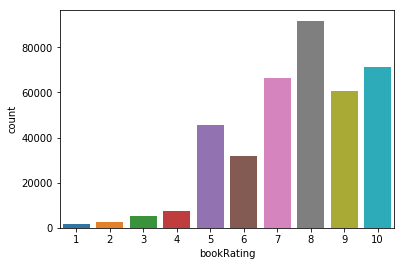

In [31]:
sns.countplot(data=ratings_data , x='bookRating')

### **Collaborative Filtering Based Recommendation Systems**

### For more accurate results only consider users who have rated atleast 100 books

In [32]:
users_cnts = ratings_data['userID'].value_counts()
users_cnts

11676     6943
98391     5689
189835    1899
153662    1845
23902     1180
235105    1020
76499     1012
171118     962
16795      959
248718     941
56399      837
197659     781
35859      777
185233     698
95359      606
114368     603
158295     567
101851     563
177458     524
204864     504
93047      501
69078      499
182085     498
135149     487
100906     484
107784     482
78973      479
23872      478
60244      476
257204     475
          ... 
216045       1
211939       1
251025       1
177106       1
173008       1
142273       1
123832       1
81059        1
83116        1
89263        1
267369       1
44433        1
42384        1
23951        1
33787        1
13698        1
269575       1
265477       1
261371       1
214252       1
109745       1
195803       1
179411       1
154831       1
152782       1
148684       1
124088       1
105655       1
103606       1
211175       1
Name: userID, Length: 68091, dtype: int64

In [33]:
#check if the user id exists in the user_cnts array and the count value is > 100
ratings_data = ratings_data[ratings_data['userID'].isin(users_cnts[users_cnts >= 100].index)]
ratings_data

,userID,ISBN,bookRating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9
1477,277427,0062507109,8
1483,277427,0132220598,8
1488,277427,0140283374,6
1490,277427,014039026X,8
1491,277427,0140390715,7


In [34]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103269 entries, 1456 to 1147615
Data columns (total 3 columns):
userID        103269 non-null int64
ISBN          103269 non-null object
bookRating    103269 non-null int64
dtypes: int64(2), object(1)
memory usage: 3.2+ MB


### Generating ratings matrix from explicit ratings


#### Note: since NaNs cannot be handled by training algorithms, replace these by 0, which indicates absence of ratings

In [35]:
ratings_data.fillna(0)

,userID,ISBN,bookRating
1456,277427,002542730X,10
1458,277427,003008685X,8
1461,277427,0060006641,10
1465,277427,0060542128,7
1474,277427,0061009059,9
1477,277427,0062507109,8
1483,277427,0132220598,8
1488,277427,0140283374,6
1490,277427,014039026X,8
1491,277427,0140390715,7


In [36]:
ratings_matrix = ratings_data.pivot(index='userID', columns='ISBN', values='bookRating').fillna(0)
userID = ratings_matrix.index
ISBN = ratings_matrix.columns
print(ratings_matrix.shape)
ratings_matrix.head()

(449, 66572)


ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
userID,,,,,,,,,,,,,,,,,,,,,
2033,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
# from surprise import Dataset,Reader
# rating scale for 1 to 10 as we have removed 0 ratings and the max rating possible is 10
# reader = Reader(rating_scale=(1, 10))
# data = Dataset.load_from_df(ratings_data[['userID', 'ISBN', 'bookRating']], reader,)
# from surprise import KNNWithMeans
# from surprise import accuracy
# from surprise.model_selection import train_test_split
# trainset, testset = train_test_split(data, test_size=.3,random_state=7)
# trainset.to_inner_iid('002542730X')
# algo = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': False})
# algo.fit(trainset) -- > getting Memory Error

### Generate the predicted ratings using SVD with no.of singular values to be 50

In [38]:
# from surprise import SVD
# from surprise import accuracy
# svd_model = SVD(n_factors=50,biased=False)
# svd_model.fit(trainset)
# test_pred = svd_model.test(testset)
# accuracy.rmse(test_pred)

In [39]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(ratings_matrix, k = 50)
U

array([[-0.0287257 ,  0.00276858, -0.00163491, ...,  0.00468381,
         0.00146285,  0.00115382],
       [-0.00316014,  0.00280843, -0.00656488, ...,  0.00106169,
         0.00106767,  0.00048237],
       [ 0.02266219,  0.00362367,  0.00392174, ...,  0.00025662,
         0.00290815,  0.001983  ],
       ...,
       [ 0.01809824, -0.00283048,  0.01413323, ...,  0.00053466,
         0.00421407,  0.00171786],
       [ 0.01331746, -0.00389798,  0.00813826, ...,  0.00109245,
         0.00485681,  0.00238477],
       [-0.00396598, -0.00564164,  0.00528432, ...,  0.00287071,
         0.00101021,  0.0006922 ]])

In [40]:
sigma

array([147.92121613, 149.3438051 , 150.07400599, 152.20116297,
       152.87416391, 154.61308307, 154.80093432, 155.95760177,
       158.05646578, 159.21079484, 159.81670657, 162.01963916,
       162.77851768, 163.33054635, 166.02489324, 166.8162391 ,
       168.04972004, 170.77485167, 171.01325686, 173.29428498,
       174.57624968, 176.65724713, 178.61913749, 180.29517222,
       182.25079063, 184.10706957, 187.61687534, 189.75276623,
       190.96966388, 195.14643609, 199.83133018, 201.70083339,
       202.18713912, 203.48697581, 207.26449173, 209.92986988,
       213.23598777, 216.88280493, 224.26954726, 231.66186197,
       235.67095629, 249.9581775 , 252.02866425, 261.24756904,
       267.98197504, 281.0120779 , 293.69539562, 379.58327277,
       634.72875357, 680.30978318])

In [41]:
Vt

array([[-3.92054115e-04, -1.12885905e-03, -7.52572700e-04, ...,
         1.21259171e-04,  1.40728079e-03, -9.39266652e-04],
       [ 1.83812046e-04,  8.04527056e-05,  5.36351371e-05, ...,
        -2.03616968e-05, -1.13338633e-05,  8.89199391e-05],
       [-6.45220069e-04, -1.81903383e-04, -1.21268922e-04, ...,
         6.52663017e-05,  5.77432315e-05, -2.03720513e-03],
       ...,
       [ 9.70964741e-05,  8.85065735e-05,  5.90043823e-05, ...,
         9.93843072e-07, -1.57012541e-06,  1.95172262e-04],
       [ 1.24358727e-04,  1.40102246e-04,  9.34014973e-05, ...,
         6.42409858e-06,  3.12147472e-05,  1.36580955e-04],
       [ 5.27949012e-05,  4.51140032e-05,  3.00760021e-05, ...,
         1.98299389e-06,  9.61038459e-06,  4.83048138e-05]])

In [42]:
sigma = np.diag(sigma)
usr_rtngs = np.dot(U, sigma)
pred_ratings = np.dot(usr_rtngs, Vt) 
preds_df = pd.DataFrame(pred_ratings, columns = ratings_matrix.columns)
preds_df.sample()

ISBN,0000913154,0001046438,000104687X,0001047213,0001047973,000104799X,0001048082,0001053736,0001053744,0001055607,...,B000092Q0A,B00009EF82,B00009NDAN,B0000DYXID,B0000T6KHI,B0000VZEJQ,B0000X8HIE,B00013AX9E,B0001I1KOG,B000234N3A
241,0.000194,-0.000215,-0.000143,-0.000215,-0.000215,0.000137,-0.000311,-0.000121,-0.000121,0.000336,...,-0.000024,0.000056,-0.000839,-0.00009,-0.007626,0.000263,0.000427,-0.000016,0.000309,-0.00152


### Take a particular user_id

### Lets find the recommendations for user with id `2110`

#### Note: Execute the below cells to get the variables loaded

In [43]:
userID = 2110

In [44]:
user_id = 2 #2nd row in ratings matrix and predicted matrix

### Get the predicted ratings for userID `2110` and sort them in descending order

In [45]:
user_preds = preds_df.iloc[user_id].sort_values(ascending=False)

In [46]:
user_preds

ISBN
0316666343    1.015397
059035342X    0.778665
0345350499    0.697309
0440214041    0.665439
044021145X    0.663549
0312195516    0.642840
0345318862    0.639465
0345313151    0.631446
0380752891    0.629143
051511605X    0.617955
043936213X    0.614288
0385504209    0.613232
0312966970    0.605433
0440213525    0.603722
0812548051    0.602907
0380752859    0.598778
0345322231    0.588352
0345318854    0.579409
0452282152    0.572168
0812548094    0.571572
0812517725    0.564544
0345322215    0.560832
0440211727    0.560544
0380759489    0.559758
0812551478    0.558102
006016848X    0.550815
0345313097    0.547583
0886774802    0.544630
0553280368    0.541396
0446310786    0.540219
                ...   
055321313X   -0.128899
0140251367   -0.131740
0836220854   -0.132223
0670835382   -0.133568
0375706062   -0.134258
0440404193   -0.134705
0679767789   -0.135518
0062501860   -0.135882
0140501800   -0.136724
0515090166   -0.137002
0140328696   -0.137862
0515095826   -0.138192
052594

In [47]:
user_data = ratings_data[ratings_data['userID'] == (userID)]

In [48]:
user_data.head()

,userID,ISBN,bookRating
14448,2110,0060987529,7
14449,2110,0064472779,8
14450,2110,0140022651,10
14452,2110,0142302163,8
14453,2110,0151008116,5


In [49]:
user_data.shape

(103, 3)

### Combine the user_data and and corresponding book data(`book_data`) in a single dataframe with name `user_full_info`

In [50]:
book_data = books[books['ISBN'].isin(user_data['ISBN'])]

In [51]:
book_data.shape

(103, 5)

In [52]:
book_data.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher
246,0151008116,Life of Pi,Yann Martel,2002,Harcourt
904,015216250X,So You Want to Be a Wizard: The First Book in ...,Diane Duane,2001,Magic Carpet Books
1000,0064472779,All-American Girl,Meg Cabot,2003,HarperTrophy
1302,0345307674,Return of the Jedi (Star Wars),James Kahn,1983,Del Rey Books
1472,0671527215,Hitchhikers's Guide to the Galaxy,Douglas Adams,1984,Pocket


In [53]:
user_full_info = user_data.merge(book_data)

In [54]:
user_full_info.head()

,userID,ISBN,bookRating,bookTitle,bookAuthor,yearOfPublication,publisher
0,2110,0060987529,7,Confessions of an Ugly Stepsister : A Novel,Gregory Maguire,2000,Regan Books
1,2110,0064472779,8,All-American Girl,Meg Cabot,2003,HarperTrophy
2,2110,0140022651,10,Journey to the Center of the Earth,Jules Verne,1965,Penguin Books
3,2110,0142302163,8,The Ghost Sitter,Peni R. Griffin,2002,Puffin Books
4,2110,0151008116,5,Life of Pi,Yann Martel,2002,Harcourt


### Get top 10 recommendations for above given userID from the books not already rated by that user

In [55]:
recs = (books[~books['ISBN'].isin(user_full_info['ISBN'])].
                   merge(pd.DataFrame(user_preds).reset_index(), how = 'left', left_on = 'ISBN'
                         ,right_on = 'ISBN'))

In [56]:
recs

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,2
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,NaN
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,0.004590
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,0.040935
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,NaN
5,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,0.007290
6,0425176428,What If?: The World's Foremost Military Histor...,Robert Cowley,2000,Berkley Publishing Group,-0.000746
7,0671870432,PLEADING GUILTY,Scott Turow,1993,Audioworks,0.004590
8,0679425608,Under the Black Flag: The Romance and the Real...,David Cordingly,1996,Random House,NaN
9,074322678X,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,NaN


In [61]:
recs = recs.rename(columns = {user_id: 'Predictions'})

In [62]:
recs.sort_values('Predictions', ascending = False).iloc[:10, :]

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,Predictions
407,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002,"Little, Brown",1.015397
2116,0345350499,The Mists of Avalon,MARION ZIMMER BRADLEY,1987,Del Rey,0.697309
2438,0440214041,The Pelican Brief,John Grisham,1993,Dell,0.665439
455,044021145X,The Firm,John Grisham,1992,Bantam Dell Publishing Group,0.663549
521,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998,Picador USA,0.642840
20670,0345318862,Golem in the Gears (Xanth Novels (Paperback)),PIERS ANTHONY,1986,Del Rey,0.639465
4810,0345313151,Bearing an Hourglass (Incarnations of Immortal...,Piers Anthony,1991,Del Rey Books,0.631446
6320,0380752891,"Man from Mundania (Xanth Trilogy, No 12)",Piers Anthony,1990,Harper Mass Market Paperbacks,0.629143
44448,051511605X,Undue Influence,Steven Paul Martini,1995,Jove Books,0.617955
8977,043936213X,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,2001,Scholastic,0.614288
